In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns

from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Drzewa decyzyjne

## 1. Zbiór danych

In [2]:
# load data
train = pd.read_csv("./data/ed-titanic-training.csv")
test = pd.read_csv("./data/ed-titanic-test.csv")
train.head(3)

,Unnamed: 0,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,1,0,2,0,3,1,1,2,0,3
2,2,1,3,0,1,0,1,0,0,1,1,4


In [3]:
# data cleaning - age
train["Age"].value_counts()

1     447
2     253
0     111
3      69
65      3
70      3
71      2
66      1
80      1
74      1
Name: Age, dtype: int64

In [4]:
train.loc[train['Age'] >= 65, ['Age']] = 3
test.loc[test['Age'] >= 65, ['Age']] = 3

train["Age"].value_counts()

1    447
2    253
0    111
3     80
Name: Age, dtype: int64

## 2. Korelacja Pearsona

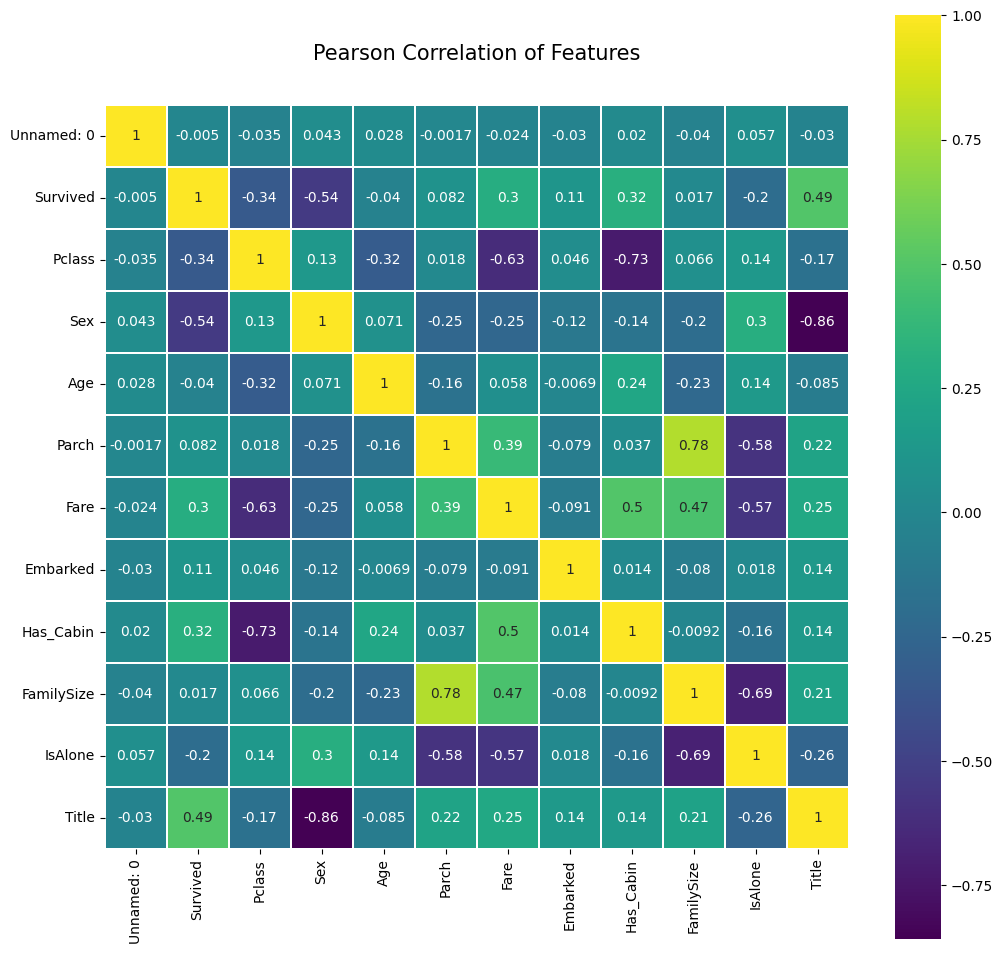

In [5]:
# pearson correlation
colormap = plt.cm.viridis

plt.figure(figsize=(12,12))
plt.title("Pearson Correlation of Features", y=1.05, size=15)
sns.heatmap(
    train.astype(float).corr(),
    linewidths=0.1,
    vmax=1.0, 
    square=True, 
    cmap=colormap, 
    color="white", 
    annot=True
)

plt.show()

Z etykietą przeżycia najbardziej skorelowane są takie jak etykiety jak płeć, tytuł czy klasa pasażera (największe wartości bezwzględne). Można też zauważyć, że płeć jest bardzo skorelowana z tytułem, natomiast klasa pasażera mocno jest skorelowana z tym, czy pasażer miał prywatną kabinę oraz z opłatą za rejs. Widać też, że jeśli ktoś był sam, to miał najpewniej małą rodzinę i większą opłatę.

## 3. Przeżywalność a tytuł

In [6]:
# survive coeffictient per title
pd.crosstab(index=train['Title'], columns=train['Survived'], normalize="index")

Survived,0,1
Title,,
1,0.843327,0.156673
2,0.425000,0.575000
3,0.206349,0.793651
4,0.297297,0.702703
5,0.652174,0.347826


Najwięcej pasażerów przeżyło spośród tych co mieli tytuł 3 lub 4.

## 4. Najlepsza głębokość drzewa

Best acc for depth 3 and entropy criterion


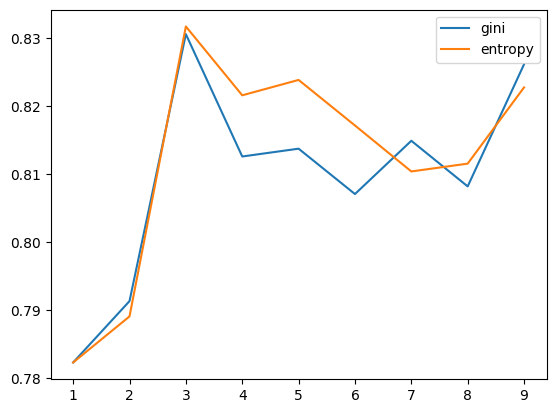

In [7]:
# choose best tree depth with k fold
features_cols = train.columns[2:]
train_X_original = np.array(train[features_cols])
train_y_original = np.array(train["Survived"])


def cross_val_mean(estimator, X: np.ndarray, y: np.ndarray, k=10):
    return np.mean(cross_val_score(estimator, X, y, cv=k))


depths = list(range(1, len(features_cols)))
criterions = ["gini", "entropy"]

max_acc = 0
best_depth = None
best_criterion = None

for c in criterions:
    accs = [cross_val_mean(DecisionTreeClassifier(max_depth=d, criterion=c), train_X_original, train_y_original) for d in depths]
    actual_max_acc = max(accs)
    if actual_max_acc > max_acc:
        max_acc, best_depth, best_criterion = actual_max_acc, depths[accs.index(actual_max_acc)], c
    plt.plot(depths, accs)

print(f"Best acc for depth {best_depth} and {best_criterion} criterion")

plt.legend(criterions)
plt.show()

Za równo dla kryterium podziału *gini* jak i *entropy* największą dokładność klasyfikacji uzyskują drzewa o głębokości 3. Ogólnie też widać, że nico lepiej sprawdza się kryterium podziału *entropy*.

## 5.-7. Wytrenowane drzewo decyzyjne

In [8]:
#  build a tree
tree = DecisionTreeClassifier(max_depth=best_depth, criterion=best_criterion)
tree.fit(train_X_original, train_y_original)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [9]:
# predictions
test_X_original = np.array(test[features_cols])

y_pred = tree.predict(test_X_original)
predictions_df = pd.DataFrame({"Survived prediction": y_pred}).join(test[features_cols])

# save to file
predictions_df.to_csv("test_decision_tree_prediction.csv")

predictions_df

,Survived prediction,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,2,0,0,2,0,1,1,1
1,1,3,0,2,0,0,0,0,2,0,3
2,0,2,1,3,0,1,2,0,1,1,1
3,0,3,1,1,0,1,0,0,1,1,1
4,1,3,0,1,1,1,0,0,3,0,3
...,...,...,...,...,...,...,...,...,...,...,...
413,0,3,1,2,0,1,0,0,1,1,1
414,0,1,0,2,0,3,1,1,1,1,5
415,0,3,1,2,0,0,0,0,1,1,1
416,0,3,1,2,0,1,0,0,1,1,1


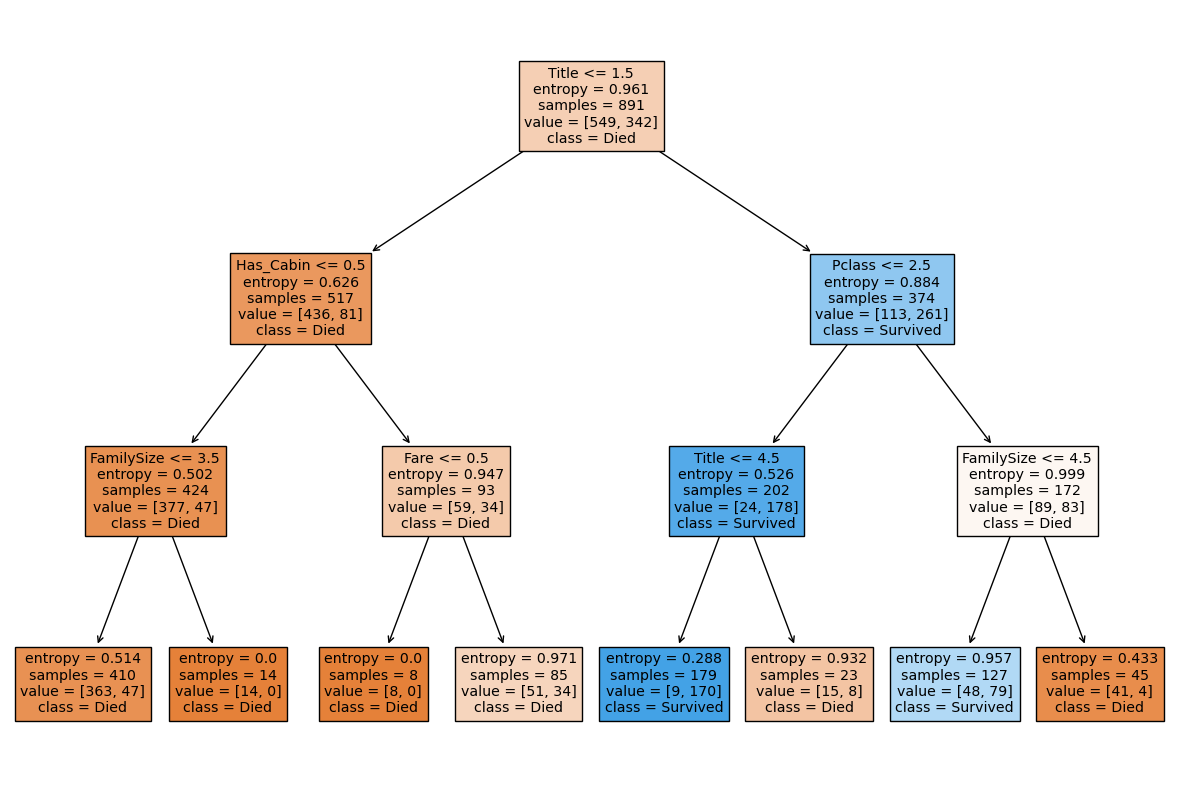

In [10]:
# visulaize tree 
plt.figure(figsize=(15, 10))
sk.tree.plot_tree(tree, feature_names=features_cols, class_names=["Died", "Survived"], filled=True)
plt.show()

Drzewo decyzyjne w pierwszej kolejność sprawdza tytuł pasażera – jak pokazano w punkcie 2. Jest to cecha silnie związana z przeżyciem. W przypadku pasażerów o numerze tytułu większym niż lub równym 2 w dalszej kolejności sprawdzana jest klasa pasażera. Pasażerów z tytułem numer 1 drzewo zawsze sklasyfikuje jako tych co nie przeżyli., choć jak pokazano w punkcie 3. 16% z nich przeżyło. Ogólnie też można zauważyć, że niektóre cechy, np. rozmiar rodziny, mimo że dla całego zbioru danych nie są mocno skorelowane z przeżyciem, to pewną grupę pasażerów (tytuł większy niż 1 oraz trzecia klasa pasażera) dzielą na tych co przeżyli lub nie.

## 8. Wpływ parametrów drzewa na jego dokładność

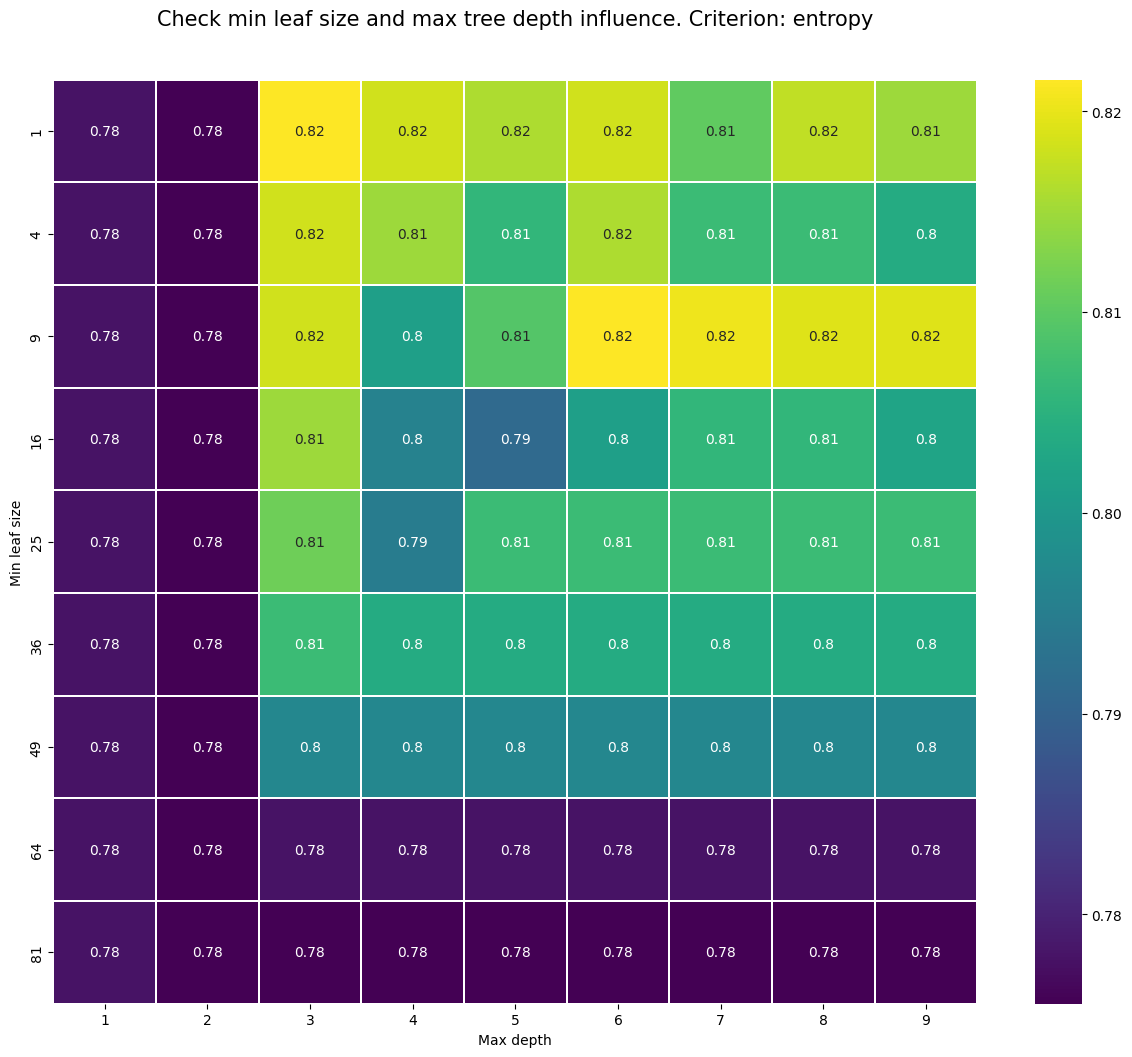

In [11]:
# check tree parameters influence, test with k fold
def tree_params_influence(
    criterion: str, 
    min_leaf_sizes: list[int], 
    max_depths: list[int], 
    X: np.ndarray,
    y: np.ndarray
):
    results = np.zeros((len(min_leaf_sizes), len(max_depths)))
    for (i, min_leaf_size), (j, max_depth) in product(enumerate(min_leaf_sizes), enumerate(max_depths)):
        tree = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_leaf_size)
        results[i, j] = cross_val_mean(tree, X, y, k=4)
    results_df = pd.DataFrame(data=results, index=min_leaf_sizes, columns=max_depths)
    plt.figure(figsize=(15, 12))
    plt.title(f"Check min leaf size and max tree depth influence. Criterion: {criterion}", y=1.05, size=15)
    heatmap = sns.heatmap(results_df, linewidths=0.1, square=True, cmap=plt.cm.viridis, color="white", annot=True)
    heatmap.set(xlabel="Max depth", ylabel="Min leaf size")
    plt.show()


min_leaf_sizes_to_check = [i**2 for i in range(1, 10)]

tree_params_influence("entropy", min_leaf_sizes_to_check, depths, train_X_original, train_y_original)

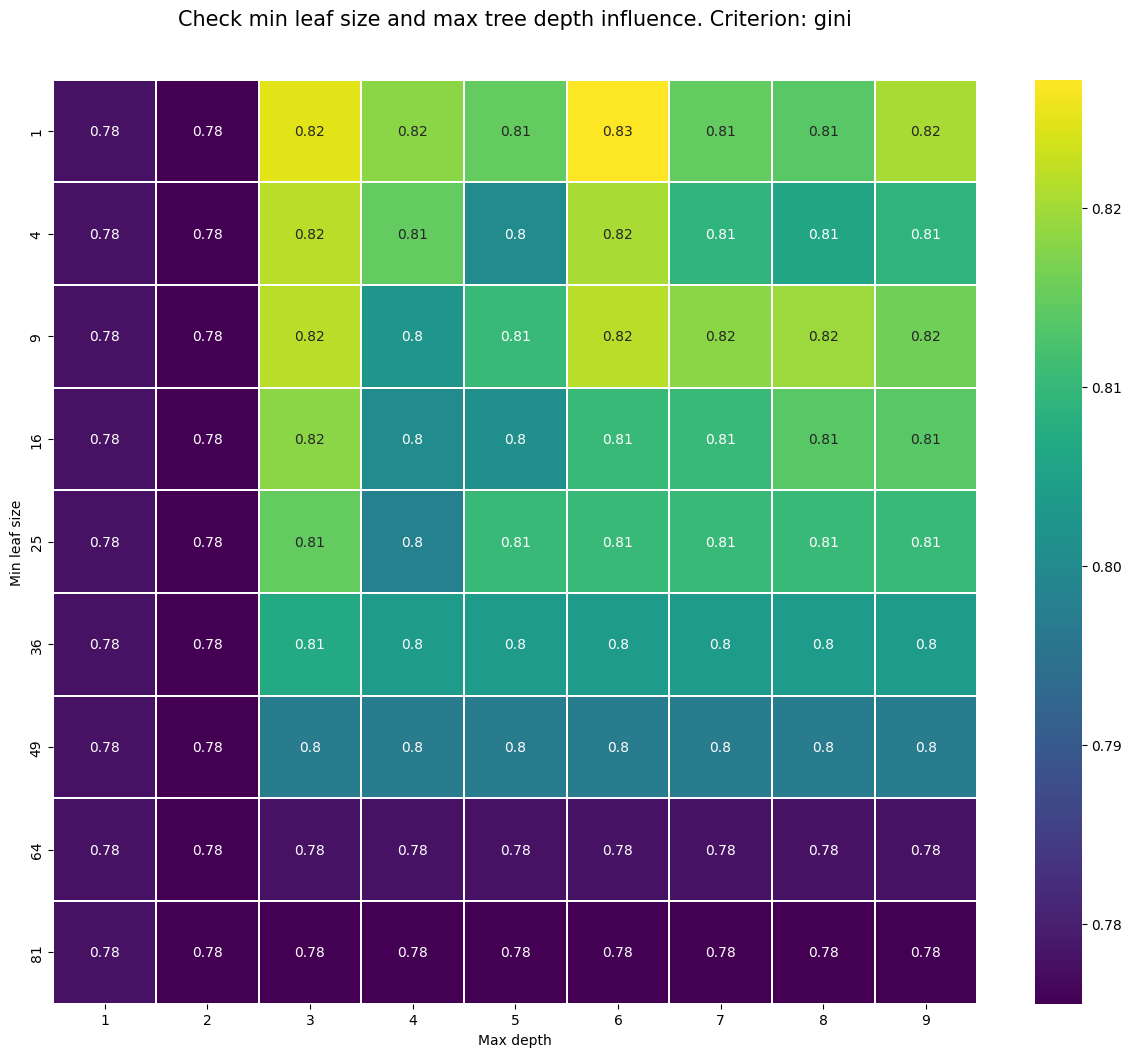

In [12]:
tree_params_influence("gini", min_leaf_sizes_to_check, depths, train_X_original, train_y_original)

Do sprawdzania dokładności dla różnych parametrów wykorzystano k-fold z k=4.

Niezależnie od wykorzystanego kryterium podziału, wpływ maksymalnej głębokości drzewa i minimalnego rozmiaru drzewa jest podobny. Generalnie widać, że tym mniejszy minimalny rozmiar liścia, tym lepsza uzyska dokładność, choć dla głębokości drzewa 4 dokładność spada. Mała wielkość liścia może pozwalać na lepsze dopasowanie się do danych, jednak przy dłużej głębokości drzewa dobrze jest ograniczyć tą własność drzewa, aby zachowało zdolność do generalizacji. 

Dużo większy wpływa ma maksymalna głębokość drzewa. Widać, że niezależnie od wielkości minimalnej liścia czy wykorzystanego kryterium podziału, niemal zawsze najlepsze są drzewa o głębokości 3. Ponownie widać, że lepszym kryterium podziału dla tych danych jest entropia.  

Przy k-fold z k=4 najlepsze reulataty dają drzewa o maksymalnej głębokości 6 i minimalnej wielkości liścia około 9, więc zbuduję nowe drzewo o takich parametrach. 

## 9.-11. Badanie jakości klasyfikatora

In [13]:
# split train dataset
X_train, X_test, y_train, y_test = train_test_split(train_X_original, train_y_original, test_size=0.25, random_state=324)

In [14]:
# new tree
tree = DecisionTreeClassifier(max_depth=6, criterion=best_criterion, min_samples_leaf=9)
tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=9)

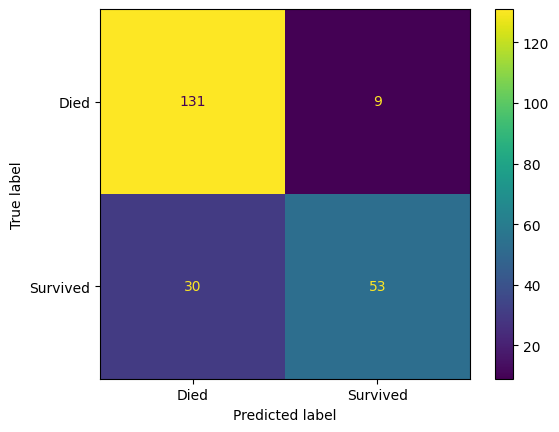

In [15]:
# predictions
y_pred = tree.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Died", "Survived"])
disp.plot()
plt.show()

In [16]:
def get_classification_quality(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    total_acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    return pd.DataFrame({
        f"accuracy": [total_acc],
        f"average precision-recall":[(precision + recall) / 2],
        f"f1 score": [f1],
    })


get_classification_quality(tree, X_test, y_test)

,accuracy,average precision-recall,f1 score
0,0.825112,0.810693,0.800733


Na confusion  matrix widać, że klasyfikator lepiej rzadziej się myli, jeśli ma sklasyfikować pasażera, który w rzeczywistości nie przeżył. Widać jednak, że mimo to, f1-score dużo nie odbiega od dogólnej dokładności.

# Klasyfikator k-NN

## Zbiory danych

In [17]:
# NYT dataset 
nyt_df = pd.read_csv("./data/nyt-frame.csv", header=0)
nyt_data = nyt_df.iloc[:, 9:].values

# pca
nyt_pca = PCA(n_components=10)
nyt_X = nyt_pca.fit_transform(nyt_data)

# classed
nyt_y = (nyt_df.iloc[:, 1] == "art").values.astype(np.int0)

In [18]:
# iris dataset
iris = load_iris()
iris_X = iris.data
iris_y = iris.target

In [19]:
# scale both datasets
nyt_X = StandardScaler().fit_transform(nyt_X)
iris_X = StandardScaler().fit_transform(iris_X)

## Zbadanie wpływu parametru k, użytej metryki oraz wprowadzenia wag odległości

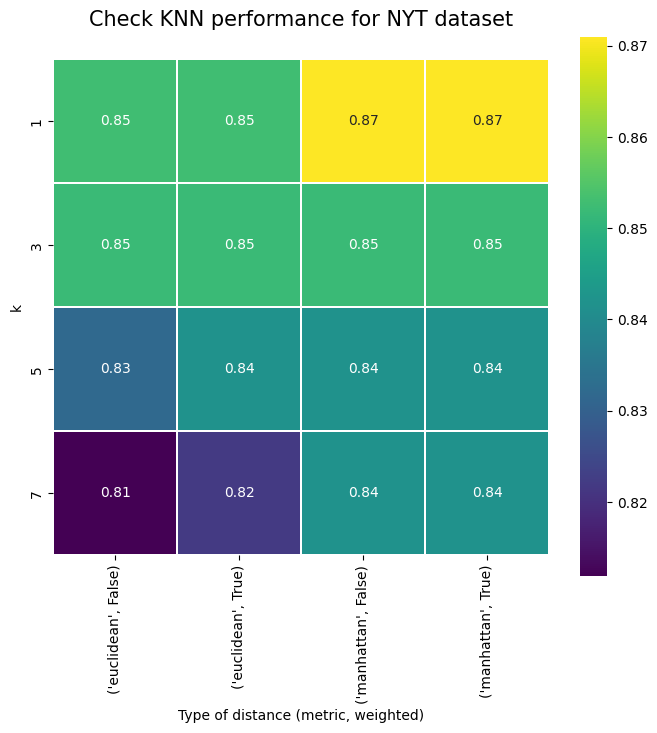

In [20]:
def test_knn(ks: list[int], metrics: list[str], X: np.ndarray, y: np.ndarray, name: str):
    distance_types =  list(product(metrics, (False, True)))
    results = np.zeros((len(ks), len(distance_types)))
    for i, k in enumerate(ks):
        for j, (metric, weighted) in enumerate(distance_types):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights="distance" if weighted else "uniform")
            results[i, j] = cross_val_mean(knn, X, y)
    results_df = pd.DataFrame(data=results, index=ks, columns=distance_types)
    plt.figure(figsize=(8, 7))
    plt.title(f"Check KNN performance for {name} dataset", y=1.05, size=15)
    heatmap = sns.heatmap(results_df, linewidths=0.1, square=True, cmap=plt.cm.viridis, color="white", annot=True)
    heatmap.set(xlabel="Type of distance (metric, weighted)", ylabel="k")
    plt.show()


metrics = ["euclidean", "manhattan"]
ks = [1, 3, 5, 7]

test_knn(ks, metrics, nyt_X, nyt_y, "NYT")

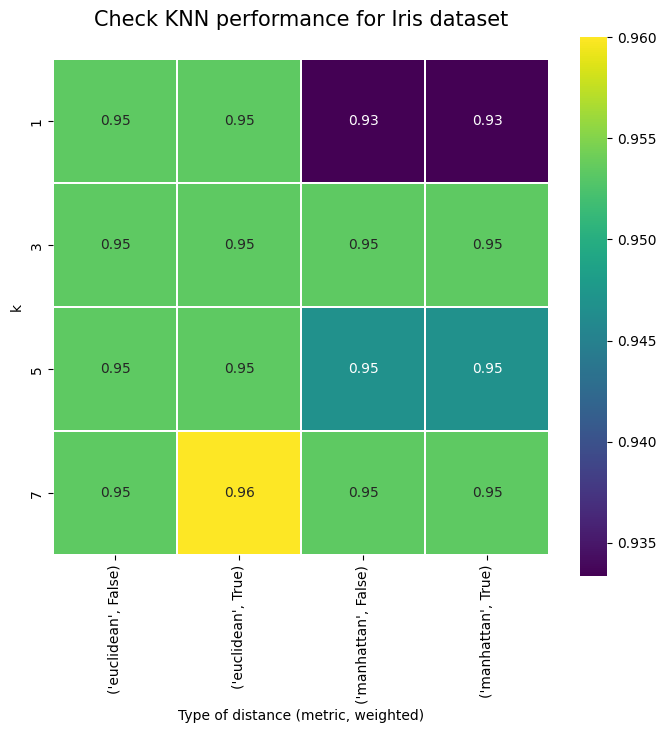

In [21]:
test_knn(ks, metrics, iris_X, iris_y, "Iris")

Oba zbiory danych zostały przeskalowane. 

Dla zbioru NYT, najlepsze wyniki uzyskano dla zaledwie jednego sąsiada. Ogólnie lepiej wypadała też metryka *gini*. Może to oznaczać, że ponieważ jest to 10 wymiarowy zbiór danych, dalsi sądzi mogą być tak naprawdę dość odlegli, co oznacza, że ich klasy są mało miarodajne z punktu widzenia klasyfikacji. 

Dla zbioru Irsis nieco lepiej wypada KNN z metryką euklidesową. Zastosowanie większego k polepsza jakość klasyfikatora KNN – największa dla k=7. Oznacza to, że w obu przypadkach, klasy przykładów nachodzą na siebie, i po prostu trzeba sprawdzić większą ich ilość, aby uzyskać poprawną predykcję.

Ważone dystanse mają mały, ale widoczny wpływ. 



# Lasy losowe

## 1. Porównanie z wytrnowanym drzewem

In [22]:
# train random forest
forest = RandomForestClassifier(n_estimators=200, criterion="gini", max_depth=9, max_samples=0.8, max_features="sqrt")
forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=9, max_samples=0.8, n_estimators=200)

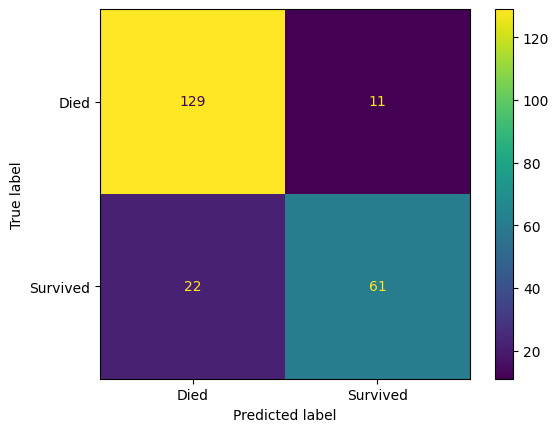

In [23]:
# predictions
y_pred_forest = forest.predict(X_test)

# confusion matrix
cm_forest = confusion_matrix(y_test, y_pred_forest)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_forest, display_labels=["Died", "Survived"])
disp.plot()
plt.show()

In [24]:
get_classification_quality(forest, X_test, y_test)

,accuracy,average precision-recall,f1 score
0,0.852018,0.839474,0.836847


Zastosowanie lasu nieskorelowanych lasów drzew losowych może poprawić wyniki. Zmieniono parametry drze: maksymalna głębokość to 9 – duże dopasowanie do danych nie zmniejsza generalizacji całego modelu, bo każde drzewo dopasowało się inaczej, więc model całościowo generalizuje problem. Zmieniono kryterium podziału na *gini*. 

Każde drzewo miało dostęp do 80% wierszy danych treningowych i do losowych, sqrt(liczba cech) = 3 cech. Cały las składa się z 200 drzew. Nie zdecydowałem się ograniczać wielkości liści. 

Dla takich parametrów, uzyskany las lepiej radzi sobie z klasyfikacją osób które przeżyły, co można zauważyć, porównując macierze konfuzji. Dzięki temu miary jakości modelu wzrosły o 3%.


## Wpływ parametrów modelu. Zbiór Iris

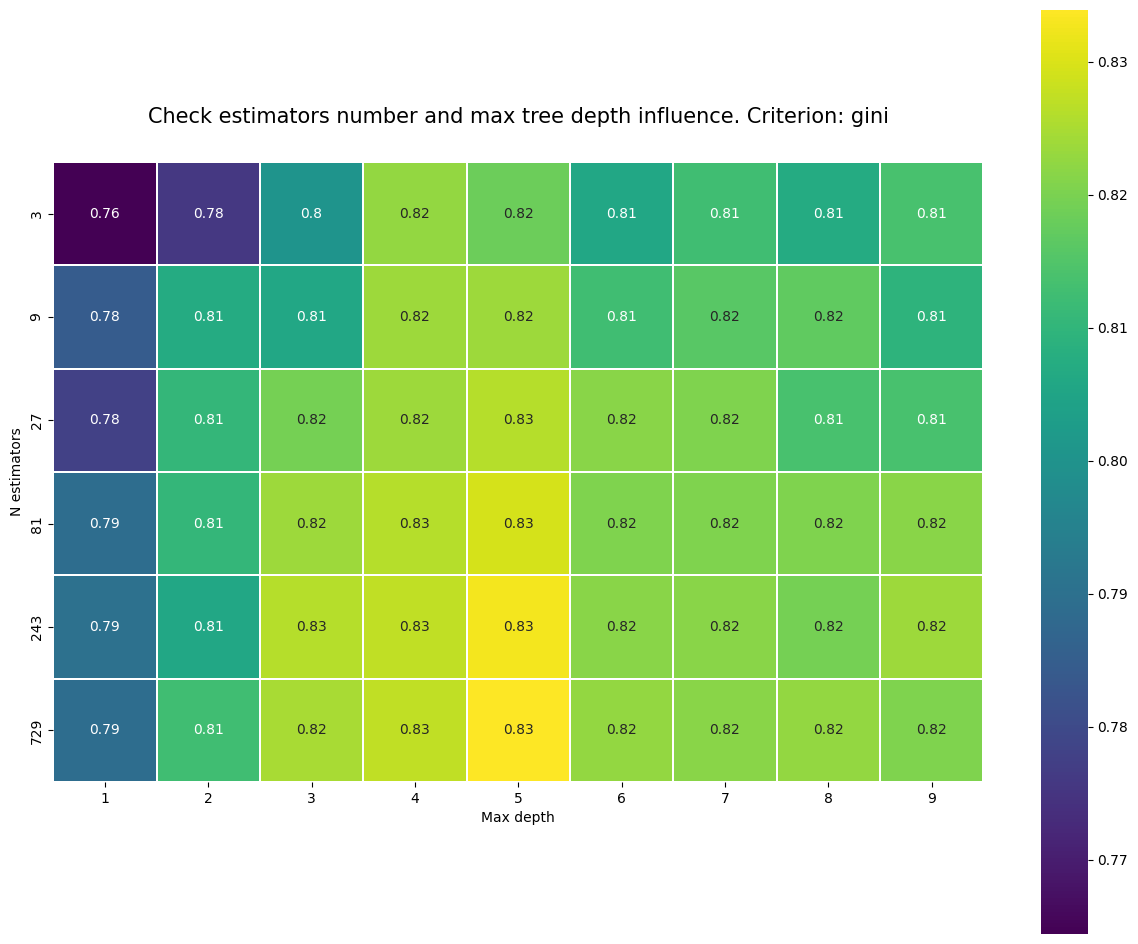

In [30]:
# check forest parameters influence (estimarors number vs max depth), test with k fold
def forest_params_influence_1(
    criterion: str, 
    ns_estimators: list[int], 
    max_depths: list[int], 
    X: np.ndarray,
    y: np.ndarray
):
    results = np.zeros((len(ns_estimators), len(max_depths)))
    for (i, ne), (j, max_depth) in product(enumerate(ns_estimators), enumerate(max_depths)):
        tree = RandomForestClassifier(criterion=criterion, max_depth=max_depth, n_estimators=ne)
        results[i, j] = cross_val_mean(tree, X, y)
    results_df = pd.DataFrame(data=results, index=ns_estimators, columns=max_depths)
    plt.figure(figsize=(15, 12))
    plt.title(f"Check estimators number and max tree depth influence. Criterion: {criterion}", y=1.05, size=15)
    heatmap = sns.heatmap(results_df, linewidths=0.1, square=True, cmap=plt.cm.viridis, color="white", annot=True)
    heatmap.set(xlabel="Max depth", ylabel="N estimators")
    plt.show()


ns_estimators = [3**i for i in range(1, 7)]

forest_params_influence_1("gini", ns_estimators, depths, train_X_original, train_y_original)

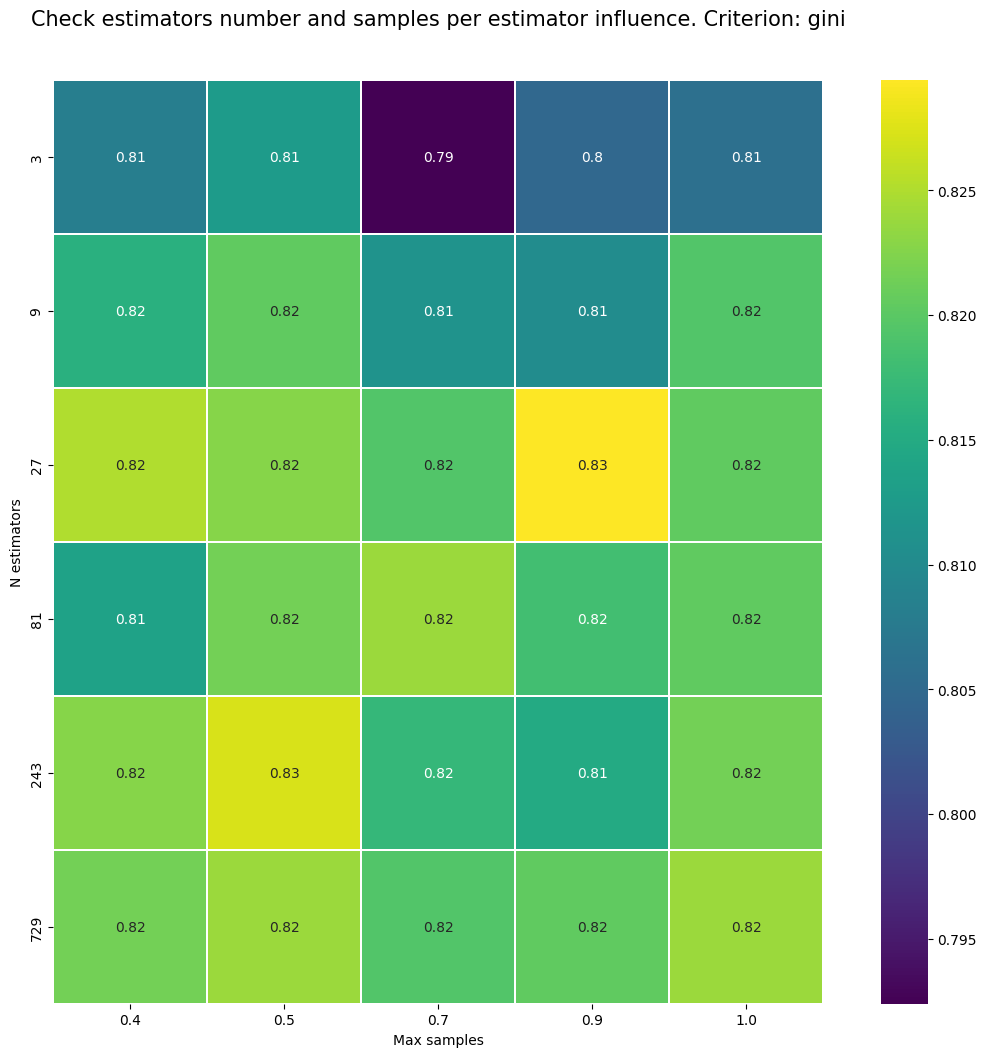

In [31]:
# check forest parameters influence (estimarors number vs samples per estimator), test with k fold
def forest_params_influence_2(
    criterion: str, 
    ns_estimators: list[int], 
    max_samples: list[int], 
    X: np.ndarray,
    y: np.ndarray
):
    results = np.zeros((len(ns_estimators), len(max_samples)))
    for (i, ne), (j, ms) in product(enumerate(ns_estimators), enumerate(max_samples)):
        tree = RandomForestClassifier(criterion=criterion, max_samples=ms, n_estimators=ne)
        results[i, j] = cross_val_mean(tree, X, y)
    results_df = pd.DataFrame(data=results, index=ns_estimators, columns=max_samples)
    plt.figure(figsize=(15, 12))
    plt.title(f"Check estimators number and samples per estimator influence. Criterion: {criterion}", y=1.05, size=15)
    heatmap = sns.heatmap(results_df, linewidths=0.1, square=True, cmap=plt.cm.viridis, color="white", annot=True)
    heatmap.set(xlabel="Max samples", ylabel="N estimators")
    plt.show()



max_samples_per_estimator = [0.4, 0.5, 0.7, 0.9, 1.0]

forest_params_influence_2("gini", ns_estimators, max_samples_per_estimator, train_X_original, train_y_original)

Na pierwszym wykresie widać, że dla danych Iris najlepsze wyniki dają lasy drzew o maksymalnej głębokości 5. Na ogół tym więcej drzew, tym lepsze wyniki. 

Na drugim wykresie widać, że przy odpowiednio dużej liczbie nieskorelowanych drzew, można ograniczyć im ilość dostępnych danych treningowych do nawet 40%, bez większej utarty na jakości, a nawet czasem może to polepszyć wyniki. Oznacza to, że las nabył większą zdolność do generalizacji.
